In [ ]:
## Importing libraries
import os
import torch
import torchvision
import torch.optim as optim
import argparse
import matplotlib
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import import_ipynb
import data_preprocessing
import gibbs_sampler_poise
import kl_divergence_calculator
#import config
from torch.utils.tensorboard import SummaryWriter
import copy
import numpy as np
from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
matplotlib.style.use('ggplot')
from torch.nn import functional as F  #for the activation function
import umap
from torchviz import make_dot
import shutil
#random.seed(4)

importing Jupyter notebook from data_preprocessing.ipynb
importing Jupyter notebook from gibbs_sampler_poise.ipynb
importing Jupyter notebook from kl_divergence_calculator.ipynb


In [ ]:
# learning parameters
latent_dim1 = 32
latent_dim2 = 16
batch_size = 128
dim_MNIST   = 784
lr = 1e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device=torch.device('cpu')
tx = transforms.ToTensor()
MNIST_TRAINING_PATH = "/home/achint/Practice_code/VAE/MNIST/MNIST/processed/training.pt"
MNIST_TEST_PATH     = "/home/achint/Practice_code/VAE/MNIST/MNIST/processed/test.pt"
SUMMARY_WRITER_PATH = "/home/achint/Practice_code/logs"
RECONSTRUCTION_PATH = "/home/achint/Practice_code/Synthetic_dataset/POISE_VAE_even_odd_MNIST/reconstructions/"
PATH = "/home/achint/Practice_code/Synthetic_dataset/POISE_VAE_even_odd_MNIST/untitled_regularized.txt"

In [3]:
# Remove the logs directory and the reconstruction directory 
if os.path.exists(RECONSTRUCTION_PATH):
    shutil.rmtree(RECONSTRUCTION_PATH)
    os.makedirs(RECONSTRUCTION_PATH)

if os.path.exists(SUMMARY_WRITER_PATH):
    shutil.rmtree(SUMMARY_WRITER_PATH)
    os.makedirs(SUMMARY_WRITER_PATH)

In [4]:
## Importing MNIST and MNIST datasets
joint_dataset_train = data_preprocessing.JointDataset(mnist_pt_path_1 = MNIST_TRAINING_PATH,
                                                      mnist_pt_path_2 = MNIST_TRAINING_PATH)
joint_dataset_test = data_preprocessing.JointDataset(mnist_pt_path_1 = MNIST_TEST_PATH,
                                                     mnist_pt_path_2 = MNIST_TEST_PATH)

joint_dataset_train_loader = DataLoader(
    joint_dataset_train,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)
joint_dataset_test_loader = DataLoader(
    joint_dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True
)

In [50]:

class VAE(nn.Module):
    def __init__(self,latent_dim1, latent_dim2, batch_size,use_mse_loss=True):
        super(VAE,self).__init__()
        self.latent_dim1 = latent_dim1
        self.latent_dim2 = latent_dim2
        self.batch_size = batch_size
        self.use_mse_loss = use_mse_loss
        self.gibbs                   = gibbs_sampler_poise.gibbs_sampler(self.latent_dim1, self.latent_dim2, self.batch_size)  
        self.kl_div                  = kl_divergence_calculator.kl_divergence(self.latent_dim1, self.latent_dim2, self.batch_size)
        ## Encoder set1(MNIST)
        self.set1_enc1 = nn.Linear(in_features = dim_MNIST,out_features = 512)
        self.set1_enc2 = nn.Linear(in_features = 512,out_features = 128)
        self.set1_enc3 = nn.Linear(in_features = 128,out_features = 2*latent_dim1)
        ## Encoder set2(MNIST)
        self.set2_enc1 = nn.Linear(in_features = dim_MNIST,out_features = 512)
        self.set2_enc2 = nn.Linear(in_features = 512,out_features = 128)
        self.set2_enc3 = nn.Linear(in_features = 128,out_features = 2*latent_dim2) 
        ## Decoder set1(MNIST)
        self.set1_dec1 = nn.Linear(in_features = latent_dim1,out_features = 128)
        self.set1_dec2 = nn.Linear(in_features = 128,out_features = 512)
        self.set1_dec3 = nn.Linear(in_features = 512,out_features = dim_MNIST)
        ## Decoder set2(MNIST)
        self.set2_dec1 = nn.Linear(in_features = latent_dim2,out_features = 128)
        self.set2_dec2 = nn.Linear(in_features = 128,out_features = 512)
        self.set2_dec3 = nn.Linear(in_features = 512,out_features = dim_MNIST)
        self.register_parameter(name='g11', param = nn.Parameter(torch.randn(latent_dim1,latent_dim2)))
        self.register_parameter(name='g22', param = nn.Parameter(torch.randn(latent_dim1,latent_dim2)))
        self.flag_initialize= 1
#         self.g11=torch.zeros(latent_dim1,latent_dim2).to(device)
#         self.g22=torch.zeros(latent_dim1,latent_dim2).to(device)        
        self.g12= torch.zeros(latent_dim1,latent_dim2).to(device)
    def forward(self,x1,x2):
        data1    = x1 #MNIST
        data2    = x2 #MNIST

        # Modality 1 (MNIST)
        x1       = F.relu(self.set1_enc1(x1))
        x1       = F.relu(self.set1_enc2(x1))  
        x1       = self.set1_enc3(x1).view(-1,2,latent_dim1)  # ->[128,2,32]
        mu1      = x1[:,0,:] # ->[128,32]
        log_var1 = x1[:,1,:] # ->[128,32]
        var1     = -torch.exp(log_var1)           #lambdap_2<0
        # Modality 2 (MNIST)
        x2       = F.relu(self.set2_enc1(x2))
        x2       = F.relu(self.set2_enc2(x2))  
        x2       = self.set2_enc3(x2).view(-1,2,latent_dim2)  # ->[128,2,32]
        mu2      = x2[:,0,:] # ->[128,32]
        log_var2 = x2[:,1,:] # ->[128,32]
        var2     = -torch.exp(log_var2)           #lambdap_2<0     
        g22      = -torch.exp(self.g22) 


# Initializing gibbs sample        
        if self.flag_initialize==1:
            z1_prior,z2_prior = self.gibbs.gibbs_sample(self.flag_initialize,
                                                        torch.zeros_like(mu1),
                                                        torch.zeros_like(mu2),
                                                        self.g11,
                                                        g22,
                                                        torch.zeros_like(mu1),
                                                        torch.zeros_like(var1),
                                                        torch.zeros_like(mu2),
                                                        torch.zeros_like(var2),
                                                        n_iterations=5000)
            z1_posterior,z2_posterior = self.gibbs.gibbs_sample(self.flag_initialize,
                                                                torch.zeros_like(mu1),
                                                                torch.zeros_like(mu2),
                                                                self.g11,
                                                                g22,
                                                                mu1, 
                                                                var1,
                                                                mu2,
                                                                var2,
                                                                n_iterations=5000)
            self.z1_prior        = z1_prior
            self.z2_prior        = z2_prior
            self.z1_posterior    = z1_posterior
            self.z2_posterior    = z2_posterior
            self.flag_initialize = 0
        z1_prior     = self.z1_prior.detach()
        z2_prior     = self.z2_prior.detach()
        z1_posterior = self.z1_posterior.detach()
        z2_posterior = self.z2_posterior.detach()
        self.z1_gibbs_prior,self.z2_gibbs_prior         = self.gibbs.gibbs_sample(self.flag_initialize,
                                                                                  z1_prior,
                                                                                  z2_prior,
                                                                                  self.g11,
                                                                                  g22,
                                                                                  torch.zeros_like(mu1),
                                                                                  torch.zeros_like(var1),
                                                                                  torch.zeros_like(mu2),
                                                                                  torch.zeros_like(var2),
                                                                                  n_iterations=5)
        self.z1_gibbs_posterior,self.z2_gibbs_posterior = self.gibbs.gibbs_sample(self.flag_initialize,
                                                                                  z1_posterior,
                                                                                  z2_posterior,
                                                                                  self.g11,
                                                                                  g22,
                                                                                  mu1,
                                                                                  var1,
                                                                                  mu2,
                                                                                  var2,
                                                                                  n_iterations=5)
        self.z1_posterior = self.z1_gibbs_posterior.detach()
        self.z2_posterior = self.z2_gibbs_posterior.detach()
        self.z1_prior = self.z1_gibbs_prior.detach()
        self.z2_prior = self.z2_gibbs_prior.detach()
        G1 = torch.cat((self.g11,self.g12),0)
        G2 = torch.cat((self.g12,g22),0)
        G  = torch.cat((G1,G2),1)

        # decoding for MNIST1
        x1 = F.relu(self.set1_dec1(self.z1_gibbs_posterior))
        x1 = self.set1_dec2(x1)
        # decoding for MNIST2
        x2 = F.relu(self.set2_dec1(self.z2_gibbs_posterior))
        x2 = self.set2_dec2(x2)
        
        
        if self.use_mse_loss:
            reconstruction1 = self.set1_dec3(x1)
            reconstruction2 = self.set2_dec3(x2)
        else:
            reconstruction1 = torch.sigmoid(self.set1_dec3(x1))
            reconstruction2 = torch.sigmoid(self.set2_dec3(x2))
        
        
        # calculating loss
        part_fun0,part_fun1,part_fun2 = self.kl_div.calc(G,self.z1_gibbs_posterior,self.z2_gibbs_posterior,self.z1_gibbs_prior,self.z2_gibbs_prior,mu1,var1,mu2,var2)
        if self.use_mse_loss:
            mse_loss = nn.MSELoss(reduction='sum')
            MSE1 = mse_loss(reconstruction1, data1)
            MSE2 = mse_loss(reconstruction2, data2)
        else:
            bce_loss = nn.BCELoss(reduction='sum')
            MSE1 = bce_loss(reconstruction1, data1)
            MSE2 = bce_loss(reconstruction2, data2)

        KLD  = part_fun0+part_fun1+part_fun2
        if self.flag_initialize==0:
#             make_dot(g22,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("g22", format="png")
#             make_dot(self.g11,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("g11", format="png")

#             make_dot(part_fun1,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("part_fun1", format="png")
#             make_dot(part_fun2,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("part_fun2", format="png")
#             make_dot(MSE1,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("MSE1", format="png")
#             make_dot(MSE2,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("MSE2", format="png")
#             make_dot(self.z1_gibbs_prior,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("z1_prior", format="png")
#             make_dot(self.z2_gibbs_prior,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("z2_prior", format="png")
#             make_dot(self.z1_gibbs_posterior,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("z1_posterior", format="png")
#             make_dot(self.z2_gibbs_posterior,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("z2_posterior", format="png")
#             make_dot(self.z2_posterior,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("z2_posterior_val", format="png")
#             make_dot(mu1,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("mu1", format="png")
#             make_dot(var1,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("var1", format="png")
#             make_dot(mu2,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("mu2", format="png")
#             make_dot(var2,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("var2", format="png")

            self.flag_initialize=5
        l1_param = 100
        l1_regularization = nn.L1Loss()
        target = torch.zeros_like(self.g11)
        loss = MSE1+MSE2+KLD+l1_param*(l1_regularization(self.g11,target)+l1_regularization(self.g22,target) )
#         print(torch.sum(MSE1))
#         print(torch.sum(MSE2))
#         print(torch.sum(l1_regularization(self.g11,target)))
#         print(torch.sum(l1_regularization(self.g22,target)))

        return reconstruction1,reconstruction2,mu1,var1,mu2,var2,loss, MSE1, MSE2, KLD

In [77]:
state = torch.load(PATH)
model = VAE(latent_dim1, latent_dim2, batch_size,use_mse_loss=True).to(device)
optimizer = optim.Adam(model.parameters(),lr=lr)

model.load_state_dict(state['state_dict'])
optimizer.load_state_dict(state['optimizer'])

for name, para in model.named_parameters():
    print(name)

g11
g22
set1_enc1.weight
set1_enc1.bias
set1_enc2.weight
set1_enc2.bias
set1_enc3.weight
set1_enc3.bias
set2_enc1.weight
set2_enc1.bias
set2_enc2.weight
set2_enc2.bias
set2_enc3.weight
set2_enc3.bias
set1_dec1.weight
set1_dec1.bias
set1_dec2.weight
set1_dec2.bias
set1_dec3.weight
set1_dec3.bias
set2_dec1.weight
set2_dec1.bias
set2_dec2.weight
set2_dec2.bias
set2_dec3.weight
set2_dec3.bias


In [78]:
def train(model,joint_dataloader,epoch):
    model.train()
    running_mse1 = 0.0
    running_mse2 = 0.0
    running_kld  = 0.0
    running_loss = 0.0
    for i,joint_data in enumerate(joint_dataloader):
        data1    = joint_data[0]
        data1    = data1.float()
        data2    = joint_data[1]
        data2    = data2.float()
        data1    = data1.to(device)
        data2    = data2.to(device)
        data1    = data1.view(data1.size(0), -1)
        data2    = data2.view(data2.size(0), -1)
        optimizer.zero_grad()
        reconstruction1,reconstruction2,mu1,var1,mu2,var2,loss, MSE1, MSE2, KLD       = model(data1,data2) 
        running_mse1 += MSE1.item()
        running_mse2 += MSE2.item()
        running_kld  += KLD.item()
        running_loss += loss.item()          #.item converts tensor with one element to number
        loss.backward()                      #.backward
        optimizer.step()                     #.step one learning step
#         for name, para in model.named_parameters():
#             print(torch.sum(para.grad))
    train_loss = running_loss/(len(joint_dataloader.dataset))
    mse1_loss = running_mse1 / (len(joint_dataloader.dataset))
    mse2_loss = running_mse2 / (len(joint_dataloader.dataset))
    kld_loss = running_kld / (len(joint_dataloader.dataset))
#     # Log this every 100 epochs
#     if epoch % 100 == 0:
    for name, param in model.named_parameters():
        writer.add_histogram(name, param.clone().cpu().data.numpy(), epoch)
    writer.add_scalar("training/loss", train_loss, epoch)
    writer.add_scalar("training/MSE1", mse1_loss, epoch)
    writer.add_scalar("training/MSE2", mse2_loss, epoch)
    writer.add_scalar("training/KLD", kld_loss, epoch)    
    
    
    
    return train_loss
    
def test(model,joint_dataloader,epoch):

    model.eval()
    running_mse1 = 0.0
    running_mse2 = 0.0
    running_kld  = 0.0
    running_loss = 0.0
    with torch.no_grad():
        for i,joint_data in enumerate(joint_dataloader):
            data1   = joint_data[0]
            data1   = data1.float()
            data2   = joint_data[1]
            data2   = data2.float()
            data1   = data1.to(device)
            data2   = data2.to(device)
            data1   = data1.view(data1.size(0), -1)
            data2   = data2.view(data2.size(0), -1)
            reconstruction1,reconstruction2,mu1,var1,mu2,var2,loss, MSE1, MSE2, KLD = model(data1,data2)  
            running_loss += loss.item()
            running_mse1 += MSE1.item()
            running_mse2 += MSE2.item()
            running_kld += KLD.item()
            #save the last batch input and output of every epoch
            if i == int(len(joint_dataloader.dataset)/joint_dataloader.batch_size) - 1:
                num_rows = 8
                both  = torch.cat((data1.view(batch_size, 1, 28, 28)[:8], 
                                  reconstruction1.view(batch_size, 1, 28, 28)[:8]))
                bothp = torch.cat((data2.view(batch_size, 1, 28, 28)[:8], 
                                  reconstruction2.view(batch_size, 1, 28, 28)[:8]))
                save_image(both.cpu(),  os.path.join(RECONSTRUCTION_PATH, f"1_outputMNIST_1_{epoch}.png"), nrow=num_rows)
                save_image(bothp.cpu(), os.path.join(RECONSTRUCTION_PATH, f"2_outputMNIST_2_{epoch}.png"), nrow=num_rows)

    test_loss = running_loss/(len(joint_dataloader.dataset))
    mse1_loss = running_mse1 / (len(joint_dataloader.dataset))
    mse2_loss = running_mse2 / (len(joint_dataloader.dataset))
    kld_loss = running_kld / (len(joint_dataloader.dataset))
    writer.add_scalar("validation/loss", test_loss, epoch)
    writer.add_scalar("validation/MSE1", mse1_loss, epoch)
    writer.add_scalar("validation/MSE2", mse2_loss, epoch)
    writer.add_scalar("validation/KLD", kld_loss, epoch)
    return test_loss

In [79]:
train_loss = []
test_loss = []
epochs = 10
writer=SummaryWriter(SUMMARY_WRITER_PATH)
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(model,joint_dataset_train_loader,epoch)
    test_epoch_loss  = test(model,joint_dataset_test_loader,epoch)
    train_loss.append(train_epoch_loss)
    test_loss.append(test_epoch_loss)     
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Test Loss: {test_epoch_loss:.4f}")

Epoch 1 of 10
Train Loss: 40.6253
Test Loss: 40.5357
Epoch 2 of 10
Train Loss: 40.6669
Test Loss: 40.1274
Epoch 3 of 10
Train Loss: 40.5532
Test Loss: 40.7218
Epoch 4 of 10
Train Loss: 40.6655
Test Loss: 40.1035
Epoch 5 of 10
Train Loss: 40.6956
Test Loss: 40.4866
Epoch 6 of 10
Train Loss: 40.5112
Test Loss: 40.2546
Epoch 7 of 10
Train Loss: 40.5476
Test Loss: 40.2782
Epoch 8 of 10
Train Loss: 40.4168
Test Loss: 40.3132
Epoch 9 of 10
Train Loss: 40.5917
Test Loss: 40.2979
Epoch 10 of 10
Train Loss: 40.6044
Test Loss: 40.1480


In [9]:
for name, para in model.named_parameters():
            print(name)

set1_enc1.weight
set1_enc1.bias
set1_enc2.weight
set1_enc2.bias
set1_enc3.weight
set1_enc3.bias
set2_enc1.weight
set2_enc1.bias
set2_enc2.weight
set2_enc2.bias
set2_enc3.weight
set2_enc3.bias
set1_dec1.weight
set1_dec1.bias
set1_dec2.weight
set1_dec2.bias
set1_dec3.weight
set1_dec3.bias
set2_dec1.weight
set2_dec1.bias
set2_dec2.weight
set2_dec2.bias
set2_dec3.weight
set2_dec3.bias


In [80]:
state = {
    'epoch': epoch,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict()}
torch.save(state, PATH)

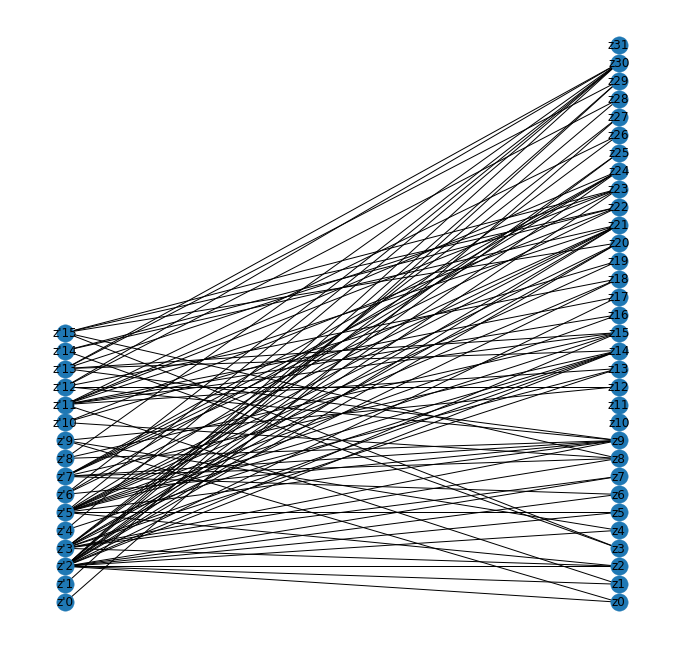

In [94]:
# Input: M scipy.sparse.csc_matrix
# Output: NetworkX Graph
import networkx as nx, numpy as np
from networkx.algorithms import bipartite
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt
from scipy import sparse

# for name,params in model.named_parameters():
#     x= params
#     break
x = model.g22
x1=x.cpu().detach().numpy()
x1[np.absolute(x1)<1]=0
sx = sparse.csr_matrix(x1)
def nx_graph_from_biadjacency_matrix(M):
    # Give names to the nodes in the two node sets
    U = [ "z{}".format(i) for i in range(M.shape[0]) ]
    V = [ "z'{}".format(i) for i in range(M.shape[1]) ]

    # Create the graph and add each set of nodes
    G = nx.Graph()
    G.add_nodes_from(U, bipartite=0, color="blue")
    G.add_nodes_from(V, bipartite=1, color="red")
    pos = {node:[0, i] for i,node in enumerate(V)}
    pos.update({node:[1, i] for i,node in enumerate(U)})

    # Find the non-zero indices in the biadjacency matrix to connect 
    # those nodes
    G.add_edges_from([ (U[i], V[j]) for i, j in zip(*M.nonzero()) ])
    #position = nx.circular_layout(G)


    return G,pos


# RB = nx.complete_bipartite_graph(32, 16)
# A  = csc_matrix(bipartite.biadjacency_matrix(RB, row_order=bipartite.sets(RB)[0]))
G,pos = nx_graph_from_biadjacency_matrix(sx)
for p in pos:  # raise text positions
    pos[p][1] += 0.25
plt.figure(3,figsize=(12,12)) 
nx.draw_networkx_labels(G, pos)
nx.draw(G, pos, with_labels=False)
#nx.draw_circular(G,  with_labels = True)
plt.show()

torch.Size([32, 16])